# 1. import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import shap

# 2. Load Data

In [ ]:
df = pd.read_csv('oasis_cross-sectional.csv')

# 3. Data preprocessing

In [ ]:
# Create binary target: dementia (CDR > 0)
df['dementia'] = (df['CDR'] > 0).astype(int)

# Drop non-predictive columns
df_clean = df.drop(['ID', 'Delay'], axis=1)

# Impute missing values
num_cols = ['Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']
imp = SimpleImputer(strategy='median')
df_clean[num_cols] = imp.fit_transform(df_clean[num_cols])


# Encode categorical
df_clean['Sex'] = df_clean['M/F'].map({'M': 1, 'F': 0})
df_clean['Handedness'] = df_clean['Hand'].map({'R': 1, 'L': 0})
df_clean = df_clean.drop(['M/F', 'Hand'], axis=1)

# Split
X = df_clean.drop(['CDR', 'dementia'], axis=1)
y = df_clean['dementia']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# Scale
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
df_clean.head()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,dementia,Sex,Handedness
0,74.0,2.0,3.0,29.0,0.0,1344.0,0.743,1.306,0,0,1
1,55.0,4.0,1.0,29.0,0.0,1147.0,0.810,1.531,0,0,1
2,73.0,4.0,3.0,27.0,0.5,1454.0,0.708,1.207,1,0,1
3,28.0,3.0,2.0,29.0,NaN,1588.0,0.803,1.105,0,1,1
4,18.0,3.0,2.0,29.0,NaN,1737.0,0.848,1.010,0,1,1


# 4. Exploratory Data Analysis


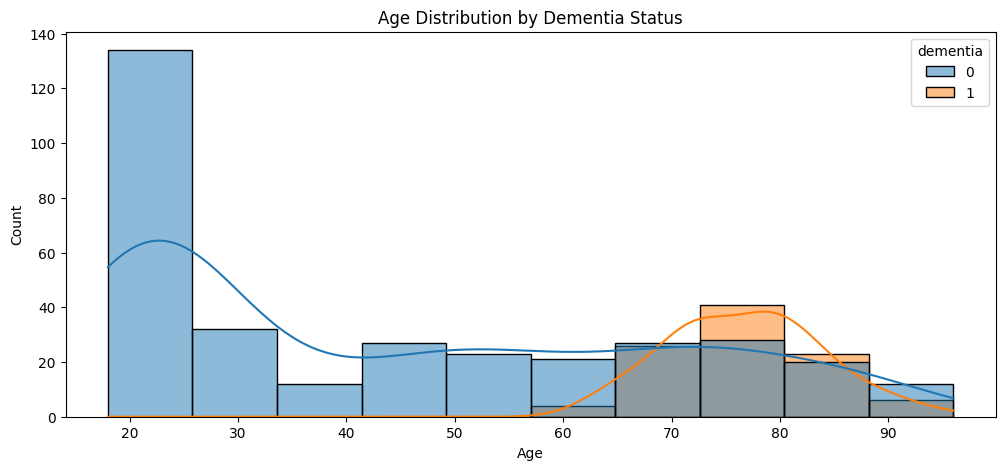

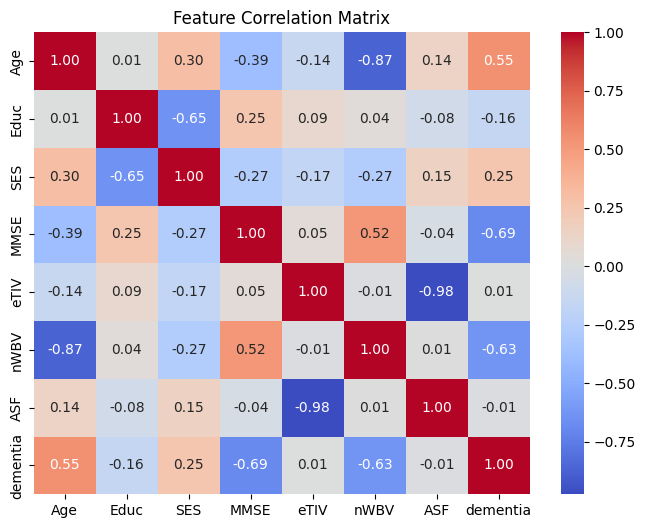

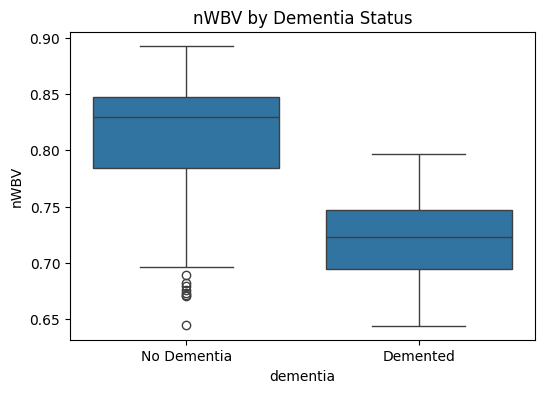

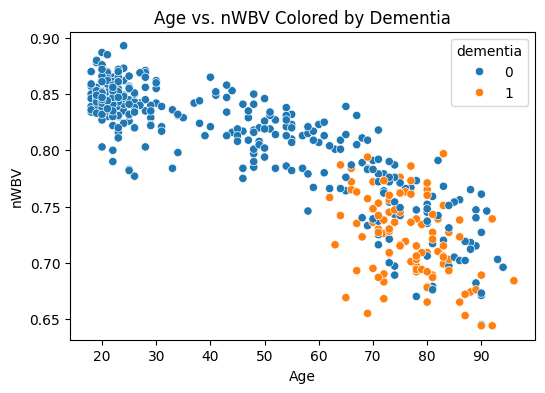

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(data=df_clean, x='Age', hue='dementia', kde=True)
plt.title('Age Distribution by Dementia Status')
plt.show()

plt.figure(figsize=(8,6))
corr = df_clean[num_cols + ['dementia']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='dementia', y='nWBV', data=df_clean)
plt.xticks([0,1], ['No Dementia','Demented'])
plt.title('nWBV by Dementia Status')
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='Age', y='nWBV', hue='dementia', data=df_clean)
plt.title('Age vs. nWBV Colored by Dementia')
plt.show()


# 5. Model Design

## 5.1. Baseline: Decision Tree

Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 1}
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        68
           1       0.76      0.65      0.70        20

    accuracy                           0.88        88
   macro avg       0.83      0.80      0.81        88
weighted avg       0.87      0.88      0.87        88

Decision Tree ROC-AUC: 0.896


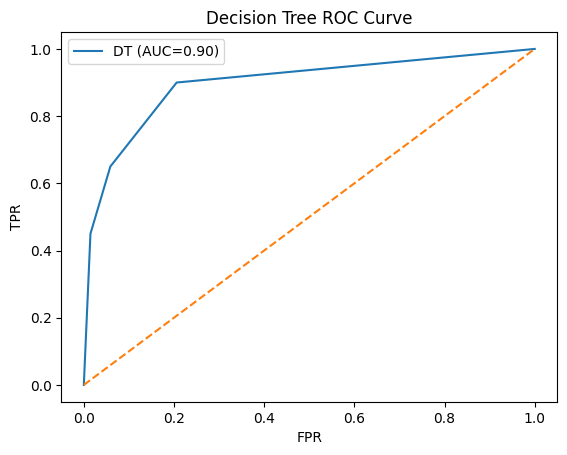

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
params_dt = {'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 5, 10]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_dt = GridSearchCV(dt, params_dt, cv=skf, scoring='roc_auc')
gs_dt.fit(X_train, y_train)

best_dt = gs_dt.best_estimator_
print("Best Decision Tree params:", gs_dt.best_params_)

y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_dt))

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_dt = auc(fpr_dt, tpr_dt)
print(f"Decision Tree ROC-AUC: {auc_dt:.3f}")

plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={auc_dt:.2f})')
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.show()

## 5.2. Advanced: XGBoost


Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        68
           1       0.77      0.85      0.81        20

    accuracy                           0.91        88
   macro avg       0.86      0.89      0.87        88
weighted avg       0.91      0.91      0.91        88

XGBoost ROC-AUC: 0.951


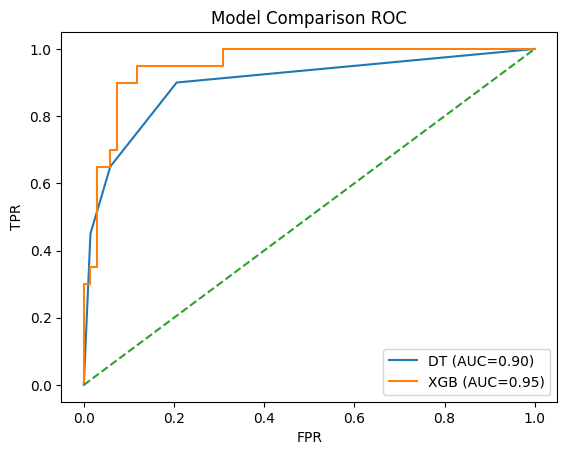

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
params_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
gs_xgb = GridSearchCV(xgb, params_xgb, cv=skf, scoring='roc_auc')
gs_xgb.fit(X_train, y_train)

best_xgb = gs_xgb.best_estimator_
print("Best XGBoost params:", gs_xgb.best_params_)

y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_xgb))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"XGBoost ROC-AUC: {auc_xgb:.3f}")

plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={auc_dt:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={auc_xgb:.2f})')
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Model Comparison ROC')
plt.legend()
plt.show()


# 6. Explainability: SHAP


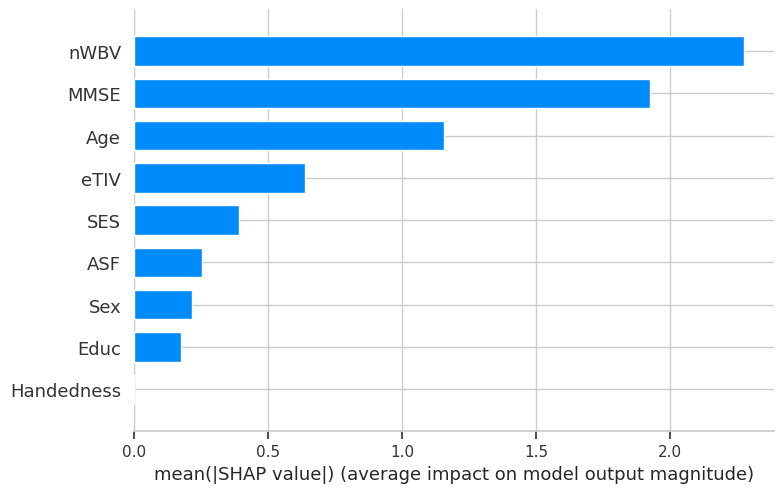

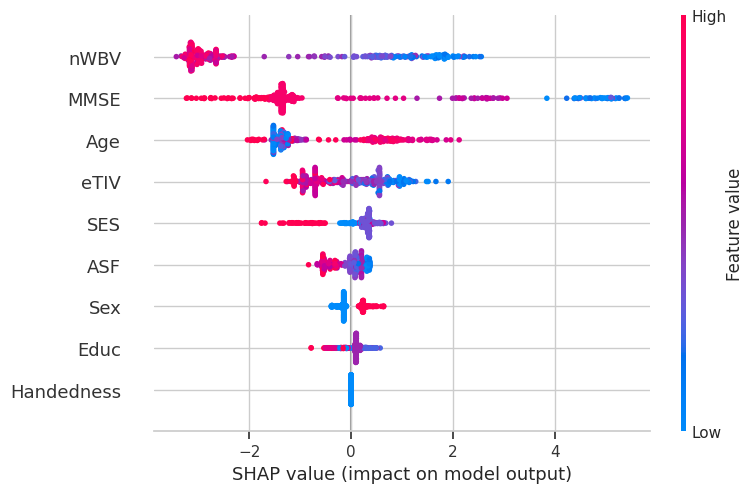

In [ ]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')
shap.summary_plot(shap_values, X_train)  # dot plot